<a href="https://colab.research.google.com/github/Himank-J/ERAV2/blob/main/S7/ERAV2_S7_Step3V2_Himank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:

- Add rotation, we guess that 5-7 degrees should be sufficient
- Add LR Scheduler

Results:
- Parameters: 7,560
- Best Training Accuracy: 99.04
- Best Test Accuracy: 99.25


Analysis:
- Model parameters can be be further reduced
- Model is not over-fitting now
- Accuracy can be pushed more by image augmentation and introducing scheduler for learning rate

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [41]:
train_transforms = transforms.Compose(
    [
        transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [42]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [43]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([128, 1, 28, 28])
torch.Size([128])


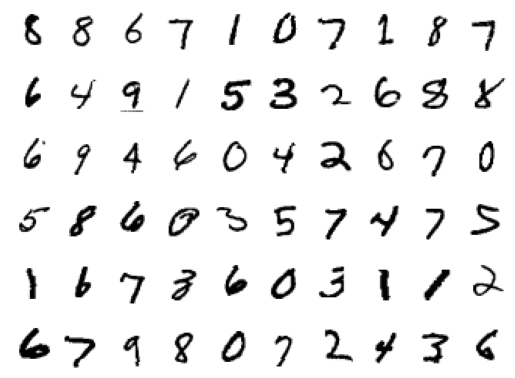

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [45]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        # nin=28 nout=26 rin=1 rout=3 RF=3
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        # nin=26 nout=24 rin=3 rout=5 RF=5
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
         # nin=24 nout=24 rin=5 rout=5 RF=5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
            # nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        # x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [46]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             576
             ReLU-12            [-1, 8, 10, 10]               0
      BatchNorm2d-13            [-1, 8, 10, 10]              16
          Dropout-14            [-1, 8,

In [47]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [48]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13596537709236145 Batch_id=468 Accuracy=79.58: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]



Test set: Average loss: 0.1597, Accuracy: 9577/10000 (95.77%)

EPOCH: 1


Loss=0.20593859255313873 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]



Test set: Average loss: 0.0914, Accuracy: 9737/10000 (97.37%)

EPOCH: 2


Loss=0.12340254336595535 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]



Test set: Average loss: 0.0596, Accuracy: 9818/10000 (98.18%)

EPOCH: 3


Loss=0.07857695966959 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]



Test set: Average loss: 0.0494, Accuracy: 9850/10000 (98.50%)

EPOCH: 4


Loss=0.07556414604187012 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]



Test set: Average loss: 0.0423, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.18272018432617188 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]



Test set: Average loss: 0.0457, Accuracy: 9857/10000 (98.57%)

EPOCH: 6


Loss=0.05303606018424034 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:22<00:00, 20.39it/s]



Test set: Average loss: 0.0347, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.08471738547086716 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]



Test set: Average loss: 0.0328, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.045169174671173096 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]



Test set: Average loss: 0.0333, Accuracy: 9905/10000 (99.05%)

EPOCH: 9


Loss=0.040688853710889816 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:23<00:00, 20.22it/s]



Test set: Average loss: 0.0311, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.023811519145965576 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]



Test set: Average loss: 0.0314, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.04588080570101738 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]



Test set: Average loss: 0.0315, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.020348312333226204 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]



Test set: Average loss: 0.0311, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.05852298438549042 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]



Test set: Average loss: 0.0308, Accuracy: 9910/10000 (99.10%)

EPOCH: 14


Loss=0.036815840750932693 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]



Test set: Average loss: 0.0320, Accuracy: 9915/10000 (99.15%)

